In [4]:
import cv2
import sys, os
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
from segment_anything import SamPredictor, sam_model_registry
from typing import List, Tuple
from custom_utils import load_images_and_boxes, plot_masks_on_images, save_masks, resize_images_and_masks

In [12]:
# 이미지와 레이블 경로
image_folder = 'data/images/'
label_folder = 'data/labels/'
mask_output_folder = 'data/masks/'  # 마스크를 저장할 폴더 경로

sam_model_type = "vit_l"
sam_ckpt = 'weights/sam_l.pt'
device = "cuda" if torch.cuda.is_available() else "cpu"
# cfg = dict(conf=0.75, task="segment", model='weights/sam_l.pt', imgsz = 512,
#                  project="./attempt")
# print(cfg)

In [10]:

# 이미지와 바운딩 박스 로드
images, all_boxes, image_names = load_images_and_boxes(image_folder, label_folder, max_images=5)

# 데이터프레임 생성
data = {
    'Image Name': image_names,
    'Bounding Boxes': all_boxes,
    'Image Data': images  # 이미지 데이터를 포함할 수 있지만, 일반적으로 분석에는 사용되지 않습니다.
}
df = pd.DataFrame(data)
# # 마스크 생성
# masks = generate_masks_with_sam(cfg, images, all_boxes)

# # 마스크와 이미지 리사이즈 (목표 크기: 512x384)
# resized_images, resized_masks = resize_images_and_masks(images, masks, target_size=(384, 512))

#  # 마스크 저장
# save_masks(resized_masks, image_names, mask_output_folder)

# # 결과 시각화
# plot_masks_on_images(resized_images, resized_masks, image_names)

/home/oi/Desktop/dbin/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


scores: tensor([0.9948, 0.9933, 0.9939], device='cuda:0')


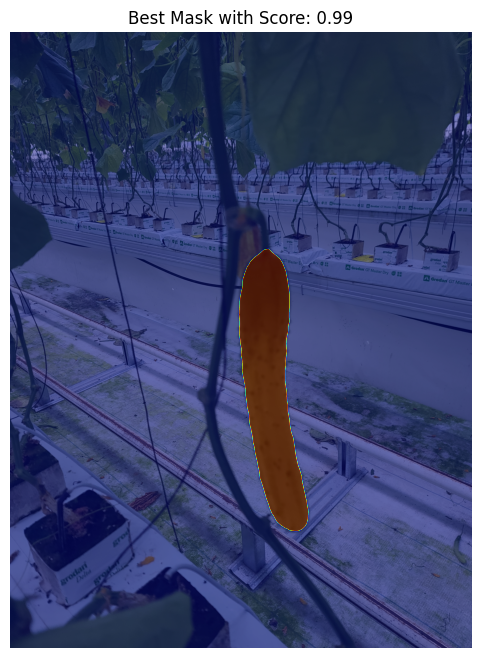

scores: tensor([0.9835, 0.9916, 0.9904], device='cuda:0')


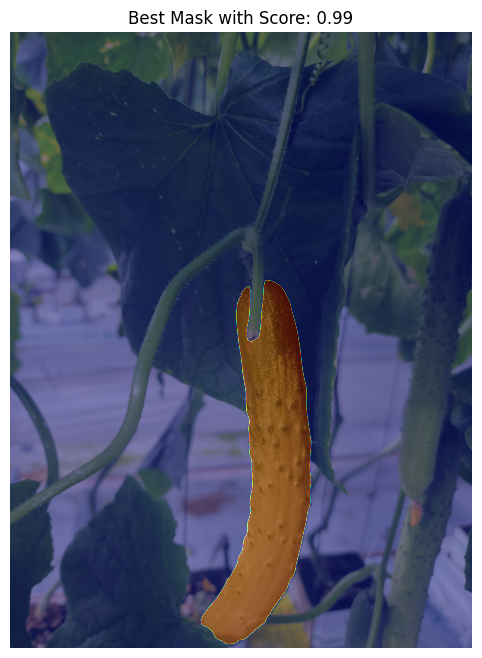

scores: tensor([0.9874, 0.9844, 0.9875], device='cuda:0')


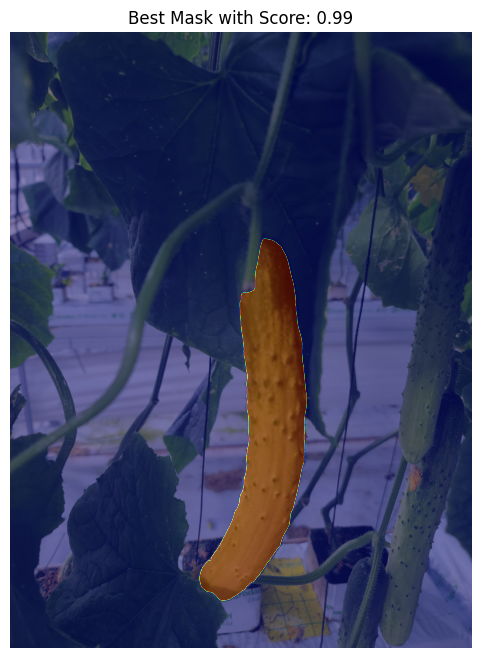

scores: tensor([0.9812, 0.9890, 0.9844], device='cuda:0')


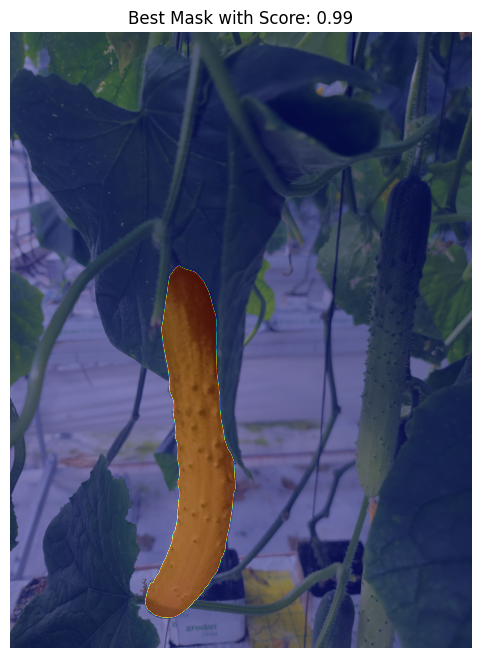

scores: tensor([0.9940, 0.9910, 0.9957], device='cuda:0')


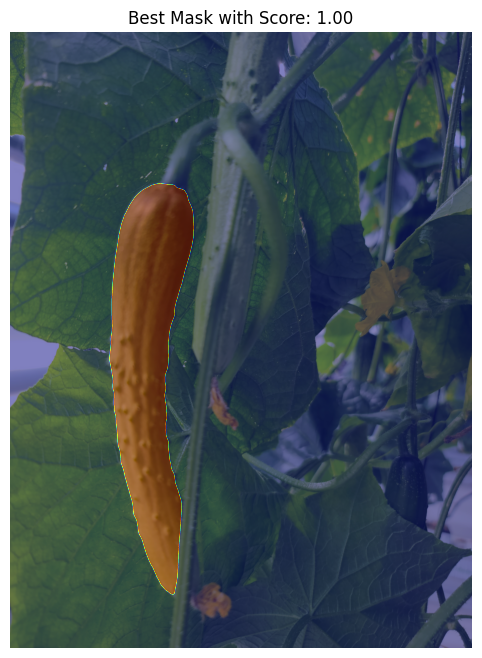

In [14]:
sam = sam_model_registry[sam_model_type](checkpoint=sam_ckpt).to(device=device)
mask_predictor = SamPredictor(sam)


for image, boxes in zip(images, all_boxes):
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()  # [1, C, H, W] 형식으로 변환
    boxes_array = np.array(boxes, dtype=np.float32)

    input_box_tensor = torch.tensor(boxes_array, device=device)
    mask_predictor.set_image(image)
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_box_tensor, image.shape[:2])

    masks, scores, _ = mask_predictor.predict_torch(
    boxes = transformed_boxes,
    multimask_output=True,
    point_coords=None,
    point_labels=None
    )
    for i in range(masks.shape[0]): ## object 개수
        object_masks = masks[i]  # Masks for the current object
        object_scores = scores[i]  # Scores for the current object
        # Find the mask index with the highest score
        print(f'scores: {scores[i]}')
        best_mask_index = torch.argmax(object_scores).item()

        # Extract the best mask
        best_mask = object_masks[best_mask_index].cpu().numpy().astype(np.uint8) * 255
        #print(f'best_mask: {best_mask}')
                # 시각화 함수 호출
        plt.figure(figsize=(8, 8))
        plt.imshow(image)  # 원본 이미지 표시
        plt.imshow(best_mask, alpha=0.5, cmap='jet')  # 마스크를 반투명하게 오버레이
        plt.title(f"Best Mask with Score: {object_scores[best_mask_index]:.2f}")
        plt.axis('off')
        plt.show()

        extracted_object = cv2.bitwise_and(image, image, mask=best_mask)
        mask_full_cropped = cv2.bitwise_and(best_mask, best_mask)
        
        x, y, w, h = cv2.boundingRect(best_mask)
        cropped_image = extracted_object[y:y+h, x:x+w]
        cropped_mask = mask_full_cropped[y:y+h, x:x+w]
        
        common_name = f"{file_id}_{labels[i]}_{i:02}.png"
        
        cropped_object = cv2.bitwise_and(cropped_image, cropped_image, mask=cropped_mask)
        
        cropped_bd_object = cv2.cvtColor(extracted_object[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
        
        # 배경을 투명하게 만들기 위해 알파 채널 추가
        b_channel, g_channel, r_channel = cv2.split(cropped_object)
        alpha_channel = np.where(cropped_mask==255, 255, 0).astype(np.uint8)  # 마스크에 따라 알파 채널 설정
        rgba_image = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
        break
    

In [8]:
# SAM 모델을 사용하여 다수의 이미지에 대해 마스크를 생성하는 함수
def generate_masks_with_sam(cfg, images: List[np.ndarray], all_boxes: List[List[List[float]]]) -> List[np.ndarray]:
    # SAM 모델 초기화
    sam = SAMPredictor(overrides=cfg)
    print(sam)
    # 결과를 저장할 리스트
    all_masks = []

    for image, boxes in zip(images, all_boxes):
        # 이미지를 PyTorch 텐서로 변환
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()  # [1, C, H, W] 형식으로 변환
        
        # 바운딩 박스가 numpy 배열인지 확인 및 변환
        boxes_array = np.array(boxes, dtype=np.float32)
        # results = sam(image, bboxes=boxes)
        
        # masks = []
        # for r in results:
        #     if r.masks is not None and r.masks.data is not None:
        #         masks_data = r.masks.data.cpu().numpy()  # 텐서를 numpy 배열로 변환
        #         masks.append(masks_data)
        # all_masks.append(masks)
        sam.set_image(image_tensor)
        # SAM 모델을 사용하여 마스크 생성
        
        masks, scores, logits = sam.inference(bboxes=boxes)
        #생성된 마스크를 결과 리스트에 추가
        all_masks.append(masks)

        # 결과 출력 (선택 사항)
        print(f'scores: {scores}', f'logits: {logits}')

    return all_masks